In [1]:
#%matplotlib notebook
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

In [2]:
field = pd.read_csv("raw_solar_pier_points.csv", header=None,
                   names=["northing", "easting", "elevation", "type"], usecols=[2, 3, 4, 5])
field.sort_values(by=["easting", "northing"], inplace=True)
field.drop_duplicates(subset=["northing", "easting", "elevation", "type"], inplace=True)
field.reset_index(drop=True, inplace=True)

In [3]:
array_counter = 0
in_the_middle = False

def assign_to_array(pile):
    global in_the_middle
    global array_counter
    if pile["type"].endswith("END"):
        if not in_the_middle:
            in_the_middle = True
            array_counter += 1
        else:
            in_the_middle = False
    return array_counter
    
field["array"] = field.apply(assign_to_array, axis=1)

In [4]:
TOLERANCE = 2

def get_straight_grade_function(array):
    p1 = array.iloc[0]
    p2 = array.iloc[-1]
    
    y1 = p1["northing"]
    z1 = p1["elevation"]
    
    y2 = p2["northing"]
    z2 = p2["elevation"]
    
    slope = (z2 - z1) / (y2 - y1)

    def line(y):
        return slope * (y - y1) + z1

    return line

def calc_straight_grade_elevation(array):
    straight_grade_func = get_straight_grade_function(array)
    array["SGE"] = array["northing"].apply(straight_grade_func)
    return array

def calc_sge_offset(pile):
    return pile["elevation"] - pile["SGE"]

def straight_grade_check(array):
    max_positive_offset = array["sge_offset"].max()
    max_negative_offset = array["sge_offset"].min()
    array["sge_check"] = max_positive_offset - max_negative_offset < TOLERANCE
    return array

def get_best_fit_line(array):
    return np.polynomial.Polynomial.fit(array["northing"], array["elevation"], 1)

def calc_best_fit_elevation(array):
    best_fit = get_best_fit_line(array)
    array["BFE"] = array["northing"].apply(best_fit)
    return array

def calc_best_fit_offset(pile):
    return pile["elevation"] - pile["BFE"]

def best_fit_check(array):
    max_positive_offset = array["bfe_offset"].max()
    max_negative_offset = array["bfe_offset"].min()
    array["bfe_check"] = max_positive_offset - max_negative_offset < TOLERANCE
    return array

output = field.groupby(by=["array"], group_keys=False).apply(calc_straight_grade_elevation)
output["sge_offset"] = output.apply(calc_sge_offset, axis=1)
output = output.groupby(by=["array"], group_keys=False).apply(straight_grade_check)

output = output.groupby(by=["array"], group_keys=False).apply(calc_best_fit_elevation)
output["bfe_offset"] = output.apply(calc_best_fit_offset, axis=1)
output = output.groupby(by=["array"], group_keys=False).apply(best_fit_check)

In [5]:
output.to_csv("pier_points_analysis.csv", index=False)

In [6]:
output.sge_check.value_counts()

True     30375
False    12180
Name: sge_check, dtype: int64

In [7]:
output.bfe_check.value_counts()

True     29130
False    13425
Name: bfe_check, dtype: int64

In [8]:
total_passed = (output["sge_check"] | output["bfe_check"]).sum()
total_arrays = output["sge_check"].count()

print(total_passed)
print(total_arrays)
print(total_passed / total_arrays)

30795
42555
0.7236517448008459


In [15]:
check_by_array = output[["array", "sge_check"]].drop_duplicates()

In [16]:
check_by_array.head()

array  sge_check
0       1       True
15      2       True
30      3       True
45      4       True
60      5       True

<IPython.core.display.Javascript object>


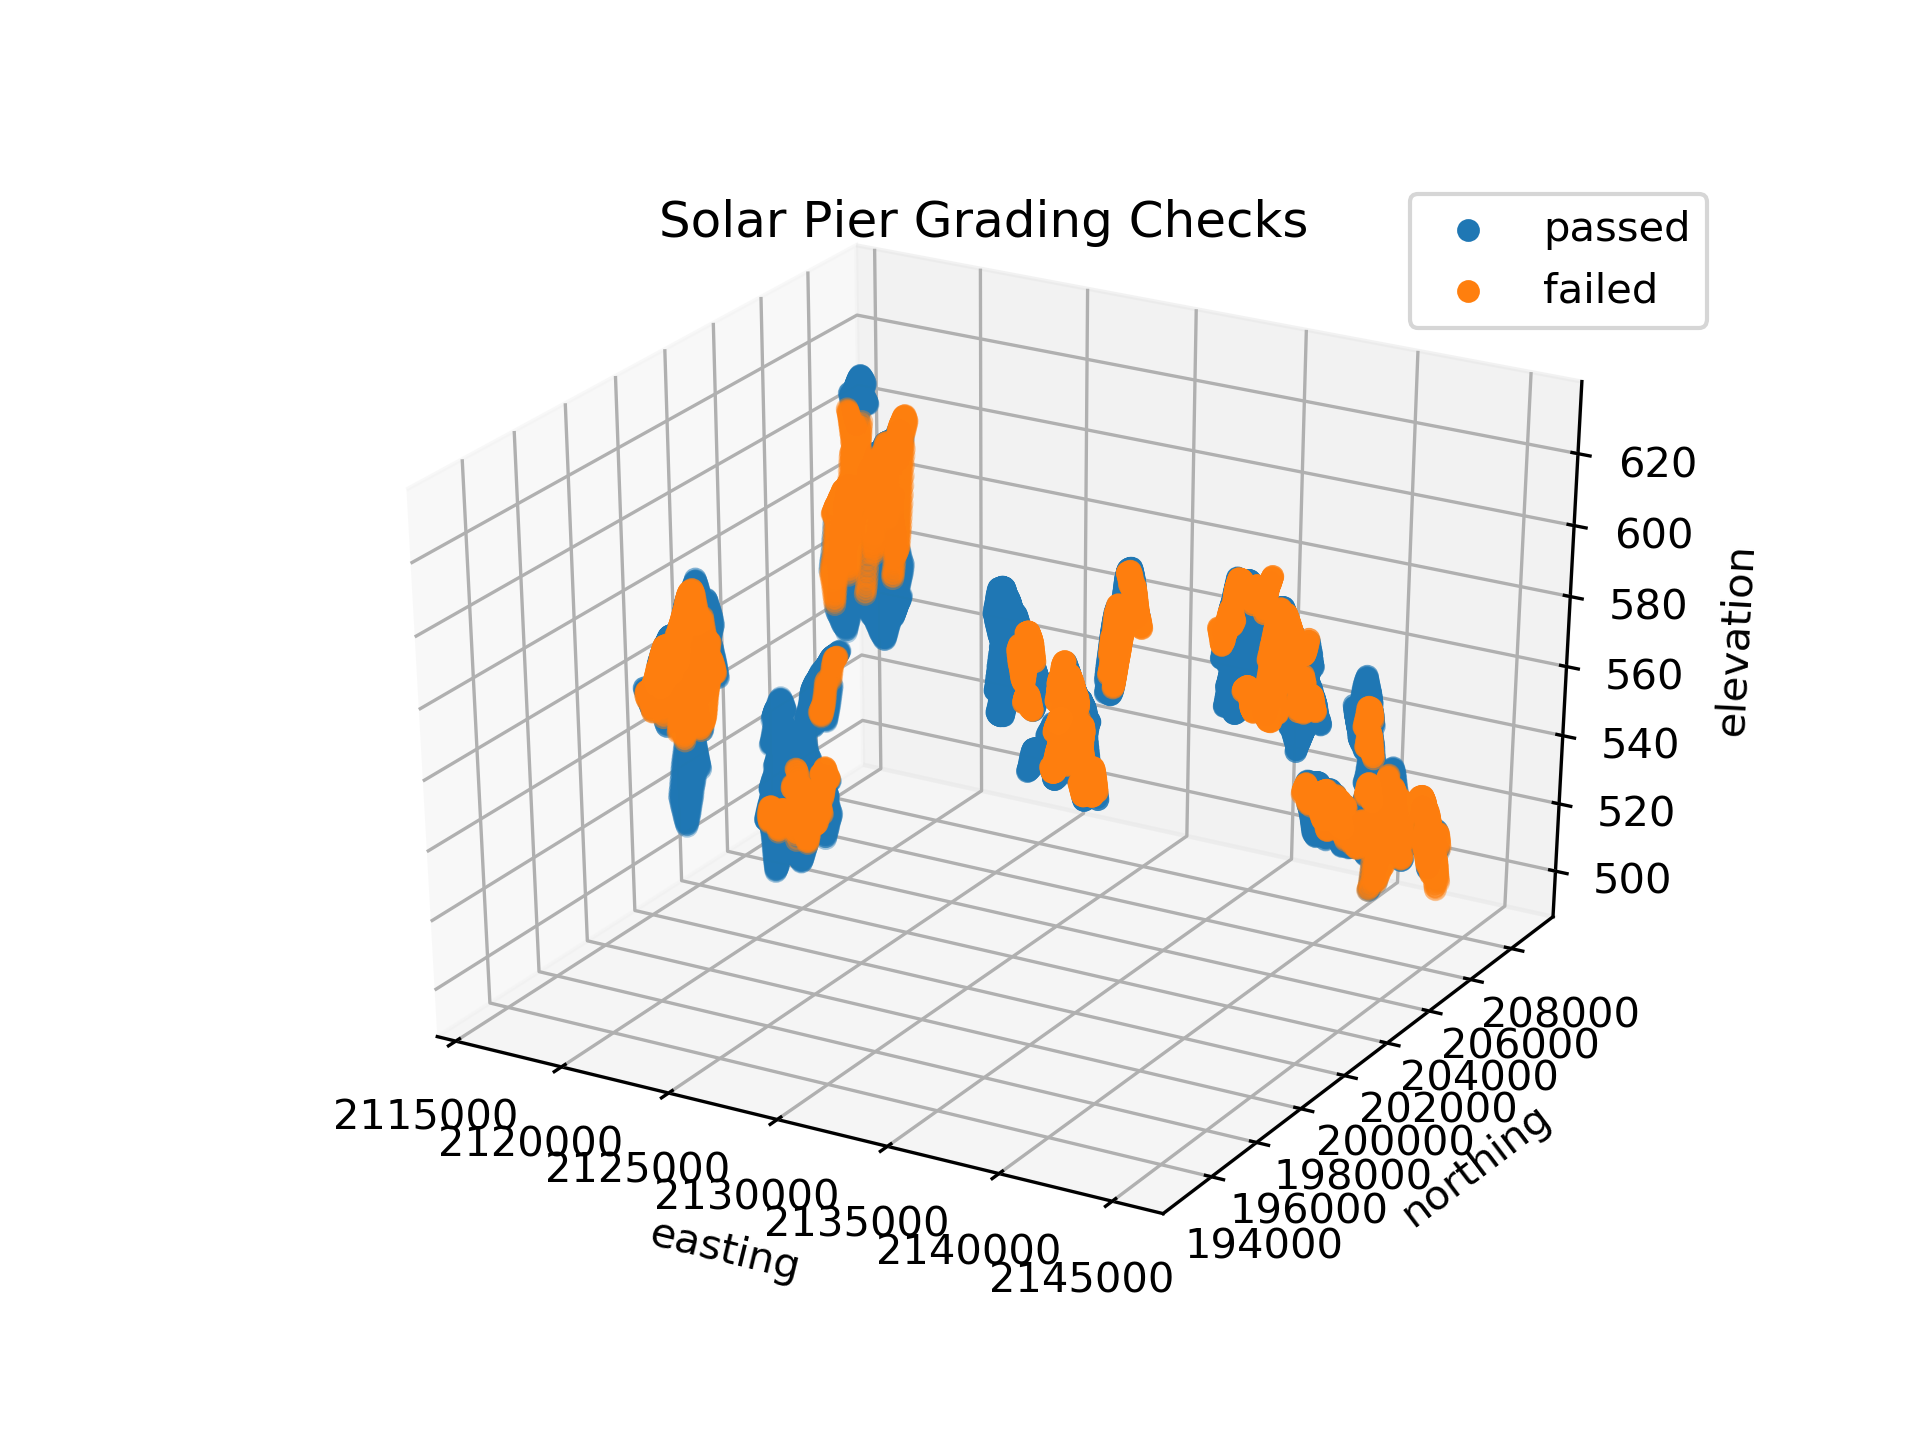

In [10]:
#passed = output[output["sge_check"] | output["bfe_check"]]
#failed = output[~output["sge_check"] & ~output["bfe_check"]]

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(passed["easting"], passed["northing"], passed["elevation"], label="passed")
#ax.scatter(failed["easting"], failed["northing"], failed["elevation"], label="failed")
#ax.set_title("Solar Pier Grading Checks")
#ax.set_xlabel("easting")
#ax.set_ylabel("northing")
#ax.set_zlabel("elevation")
#ax.legend()
#fig.show()